# Amazon Fire TV Search Forecast

___

**This project aims to make prediction on the next year Fire TV interest on the internet. The source data is taken from [Google Trend](https://trends.google.com/trends/?geo=US) with keywords "Fire TV, Roku, Apple TV" looking at the last 5 years of results. The number represent the relative amount of search appeared as compared to the peak value across all the data.**

___

**Only the Fire TV is used for the first step. A *SARIMA* Model was built using the Grid-Search best result from *auto_arima* library. A *LSTM* DNN was also built to compare the accuracy.**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('multiTimeline.csv',
                   index_col='Date', 
                   names=['Date','Fire TV', 'Roku TV', 'Apple TV'],
                   header=1,
                   parse_dates=True)

In [3]:
data.head()

,Fire TV,Roku TV,Apple TV
Date,,,
2015-08-09,14,10,39
2015-08-16,14,10,39
2015-08-23,13,9,38
2015-08-30,14,10,45
2015-09-06,15,11,97


### setting the datetime frequency with weekly intervals

In [4]:
data.index.freq = 'W'

In [5]:
data.index[0]

Timestamp('2015-08-09 00:00:00', freq='W-SUN')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2015-08-09 to 2020-08-02
Freq: W-SUN
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Fire TV   261 non-null    int64
 1   Roku TV   261 non-null    int64
 2   Apple TV  261 non-null    int64
dtypes: int64(3)
memory usage: 8.2 KB


<AxesSubplot:xlabel='Date'>

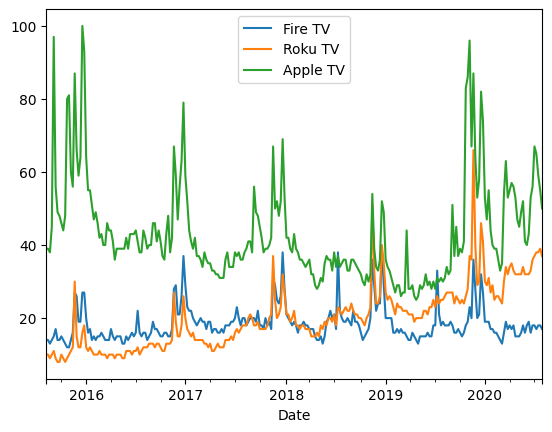

In [7]:
data.plot()

- **Apple TV got a bigger fraction of online interest.**
- **Roku is trending up as always, and got a big momemtum in the recent years.**
- **Fire TV is outrun by Roku, which haults its uptrend starting from late 2017.**
- **Strong seasonality displayed. The dominant two peaks corresponding to *Black Friday* and *Christmas Sale* in time sequence.**
- **Several other peaks correspond to *Sale day* per company. E.g. *Prime day* for Fire TV.**

In [8]:
fire = data['Fire TV']

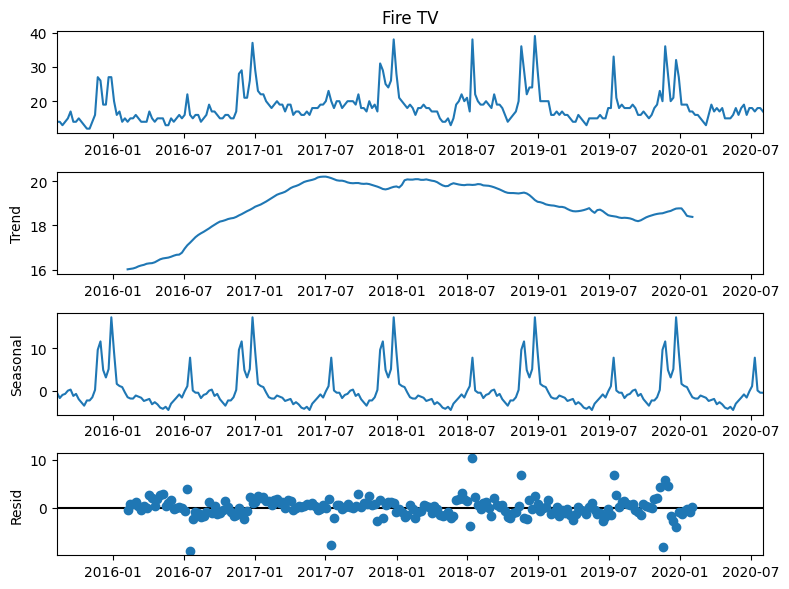

In [9]:
ets = seasonal_decompose(fire)
fig = ets.plot()
fig.set_size_inches(8,6)
plt.tight_layout();

- **Trend is going down with small slope.**
- **Clear seasonality from ETS decomposition with peaks described above.**

### finding the q, i, p parameters for the *SARIMA* model with auto_atima grid search utility.

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [11]:
auto_arima(fire,seasonal=True,m=52).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  261
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 52)   Log Likelihood                -652.353
Date:                             Tue, 11 Aug 2020   AIC                           1314.706
Time:                                     23:12:23   BIC                           1332.529
Sample:                                          0   HQIC                          1321.870
                                             - 261                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8660      0.387      2.238      0.025       0.108       1.624
ar.L1          0.8633      0.057     15.227      0.000       0.752       0.974
ma.L1         -0.5464      0.074     -7.403      0.000      -0.691      -0.402
ar.S.L52       0.6443      0.027     24.107      0.000       0.592       0.697
sigma2         7.7869      0.350     22.249      0.000       7.101       8.473
===================================================================================
Ljung-Box (Q):                       26.08   Jarque-Bera (JB):              1824.06
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                             1.83
Prob(H) (two-sided):                  0.08   Kurtosis:                        15.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
train = fire.iloc[:209]; test = fire.iloc[209:]

In [13]:
model = SARIMAX(train, order=(1,0,1), seasonal_order=(1,0,1,52))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Fire TV   No. Observations:                  209
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood                -513.592
Date:                            Tue, 11 Aug 2020   AIC                           1037.184
Time:                                    23:12:31   BIC                           1053.896
Sample:                                08-09-2015   HQIC                          1043.941
                                     - 08-04-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9867      0.018     55.971      0.000       0.952       1.021
ma.L1         -0.6550      0.067     -9.805      0.000      -0.786      -0.524
ar.S.L52       0.8390      0.044     19.283      0.000       0.754       0.924
ma.S.L52      -0.1269      0.107     -1.184      0.236      -0.337       0.083
sigma2         6.1191      0.285     21.464      0.000       5.560       6.678
===================================================================================
Ljung-Box (Q):                       30.67   Jarque-Bera (JB):              3302.91
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               3.23   Skew:                             2.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
start = len(train); end = len(train) + len(test) +1
predictions = results.predict(start, end, type='levels').rename('SARIMA predictions')

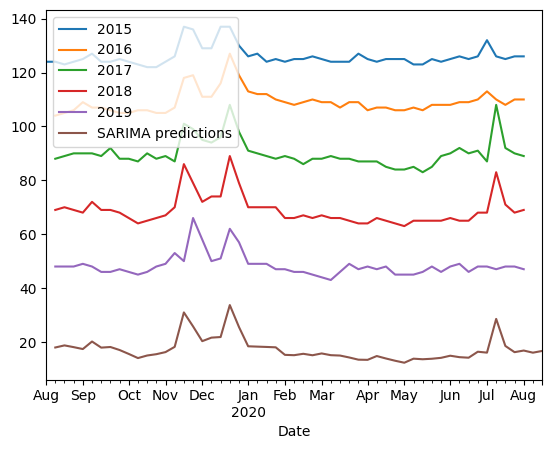

In [15]:
for i in range(5):
    year = fire.loc[f'{2015+i}-8-8':f'{2016+i}-8-8'].rename(f'{2015+i}')
    year = year.shift(periods=52*(4-i), freq='W')+130-20*(i+1)
    year.plot(legend=True)
predictions.plot(legend=True)
plt.legend(loc=2)

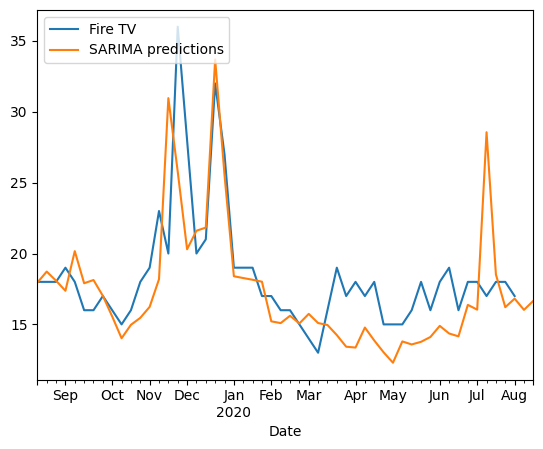

In [16]:
fire.loc[f'{2019}-8-8':f'{2020}-8-8'].plot(legend=True)
predictions.plot(legend=True)
plt.legend(loc=2)

In [17]:
from statsmodels.tools.eval_measures import rmse,mse

In [18]:
rmse_error = rmse(fire.loc[f'{2019}-8-8':f'{2020}-8-8'],predictions[:-2])
rmse_error

3.5624580109385686

In [19]:
mean = fire.loc[f'{2019}-8-8':f'{2020}-8-8'].mean()
mean

18.365384615384617

In [20]:
print(f'Percentage accuracy is {1-rmse_error/(mean)}')

Percentage accuracy is 0.8060232287237639


## The *SARIMA* model gives 80% accuracy w.r.t. the mean
___
## Next, try a simple LSTM DNN with a few epochs

In [21]:
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [22]:
scaler = MinMaxScaler()
scaler.fit(train.values.reshape(-1, 1))
train_scaled = scaler.transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

In [23]:
# define generator
n_input = 52
n_features = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)

In [30]:
model= Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history = model.fit(generator, epochs=10, verbose=1)

Epoch 1/10
157/157 [==============================] - 6s 36ms/step - loss: 0.0383
Epoch 2/10
157/157 [==============================] - 6s 35ms/step - loss: 0.0339
Epoch 3/10
157/157 [==============================] - 6s 35ms/step - loss: 0.0317
Epoch 4/10
157/157 [==============================] - 6s 37ms/step - loss: 0.0297
Epoch 5/10
157/157 [==============================] - 6s 36ms/step - loss: 0.0265
Epoch 6/10
157/157 [==============================] - 6s 37ms/step - loss: 0.0289
Epoch 7/10
157/157 [==============================] - 6s 36ms/step - loss: 0.0269
Epoch 8/10
157/157 [==============================] - 6s 37ms/step - loss: 0.0252
Epoch 9/10
157/157 [==============================] - 6s 37ms/step - loss: 0.0247
Epoch 10/10
157/157 [==============================] - 6s 37ms/step - loss: 0.0244


In [32]:
x=history.history['loss']
for i in x:
    if i > 1:
        x.remove(i)

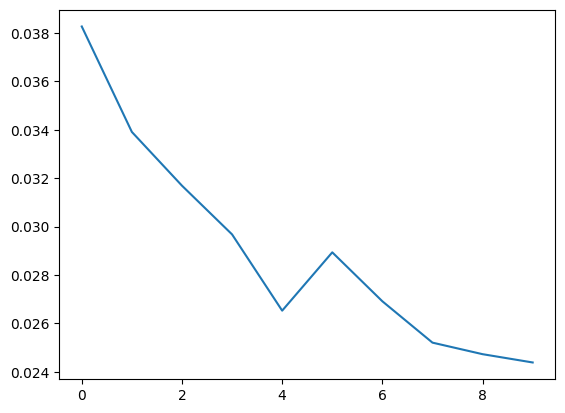

In [54]:
loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

**need to think about how to incorporate the validation data into fitting to give a sense of overfitting**

In [57]:
test_predictions = []

first_eval_batch = train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [71]:
lstm_predictions = scaler.inverse_transform(test_predictions)
test = pd.DataFrame(test)
test['LSTM predictions'] = lstm_predictions
#data.index.freq = 'W'
#test['LSTM Predictions'] = lstm_predictions

In [72]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52 entries, 2019-08-11 to 2020-08-02
Freq: W-SUN
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fire TV           52 non-null     int64  
 1   LSTM predictions  52 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


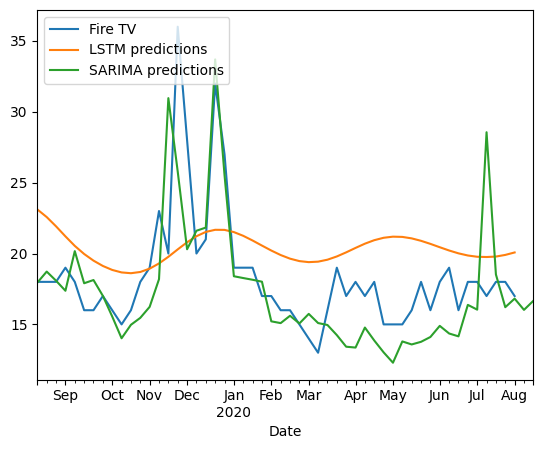

In [76]:
#fire.loc[f'{2019}-8-8':f'{2020}-8-8'].plot(legend=True, figsize=(8,6))
ax = test.plot(legend=True)
predictions.plot(legend=True, ax=ax)
plt.legend(loc=2)

## Simple classical model always is the best choice in terms of accuracy and efficiency. However, LSTM model will have to predict based on its own prediction, which grows the error with time. SARIMA composed of different additive components, not much depends on recent predicted data points.